#### Analyse Bike Store Relational Database
*work done by Fizah*  
The dataset used for this analysis is sourced from [Kaggle: Bike Store Sample Database](https://www.kaggle.com/datasets/dillonmyrick/bike-store-sample-database/code).

#### Importing Libraries

In [4]:
# 📝 Data Handling & Database Management
import pandas as pd                      # Data manipulation: pandas is essential for handling data, cleaning, and transforming.
import pandas.io.sql as sql              # SQL interface for pandas: Used to directly run SQL queries and return results as DataFrame.
import mysql.connector                    # MySQL database connector: Helps in connecting to MySQL databases for data interaction.
from sqlalchemy import create_engine     # Able to handle multiple databases: Useful for managing SQL connections and queries across different databases.
from mysql.connector import errorcode    # MySQL error handling: Useful for handling database connection errors.
import numpy as np                       # Numerical computations: Often used for matrix and array operations, helps with data manipulation in pandas.
import csv                               # Reading/Writing CSV files: Used to import/export data in CSV format.

# 📝 Date & Time Processing
import datetime                          # General date/time operations: Needed for handling datetime objects and operations.
from datetime import datetime           # Specific datetime object: Allows for more specific date/time manipulations and formatting.

# 📝 Data Visualization
import seaborn as sns                   # Statistical visualizations: Provides high-level interface for drawing attractive and informative statistical graphics.
import colorcet as cc                   # More color palettes: Provides a variety of color schemes for better visual appeal in plots.
import matplotlib.pyplot as plt          # Basic plotting: Essential for creating static, publication-quality visualizations.
import matplotlib                        # Needed to control styling and properties for Matplotlib plots (e.g., font settings).
matplotlib.rcParams['font.family'] = 'Arial'  # Customizing the font style for all Matplotlib plots.
import plotly.graph_objs as go           # Interactive visualizations (Plotly): For creating interactive plots that users can explore dynamically.

# 📝 Graph & Network Analysis
import networkx as nx                    # Graph/Network analysis: Provides tools for analyzing network structures, such as nodes, edges, shortest path, etc.



#### Create a connection to MySQL

In [ ]:
connection = mysql.connector.connect(
    host="localhost",       
    user="root",    
    password="xxxx" 
)

cursor = connection.cursor()


#### Create sales and production db

In [6]:
cursor.execute("CREATE DATABASE IF NOT EXISTS sales;")
cursor.execute("CREATE DATABASE IF NOT EXISTS production;")

#commit the transaction
connection.commit()


#### Creating tables in sales db

In [27]:
# Switch to the 'sales' schema
cursor.execute("USE sales;")

# Creating tables in 'sales' schema
cursor.execute("""
CREATE TABLE IF NOT EXISTS customers (
  customer_id INT AUTO_INCREMENT PRIMARY KEY,
  first_name VARCHAR(255) NOT NULL,
  last_name VARCHAR(255) NOT NULL,
  phone VARCHAR(25),
  email VARCHAR(255) NOT NULL UNIQUE,
  street VARCHAR(255),
  city VARCHAR(50),
  state VARCHAR(25),
  zip_code VARCHAR(5)
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS stores (
  store_id INT AUTO_INCREMENT PRIMARY KEY,
  store_name VARCHAR(255) NOT NULL,
  phone VARCHAR(25),
  email VARCHAR(255),
  street VARCHAR(255),
  city VARCHAR(255),
  state VARCHAR(10),
  zip_code VARCHAR(5)
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS staffs (
  staff_id INT AUTO_INCREMENT PRIMARY KEY,
  first_name VARCHAR(50) NOT NULL,
  last_name VARCHAR(50) NOT NULL,
  email VARCHAR(255) NOT NULL UNIQUE,
  phone VARCHAR(25),
  active TINYINT NOT NULL,
  store_id INT NOT NULL,
  manager_id INT,
  FOREIGN KEY (store_id) REFERENCES stores (store_id) ON DELETE CASCADE ON UPDATE CASCADE,
  FOREIGN KEY (manager_id) REFERENCES staffs (staff_id) ON DELETE NO ACTION ON UPDATE NO ACTION
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS orders (
  order_id INT AUTO_INCREMENT PRIMARY KEY,
  customer_id INT NOT NULL,
  order_status TINYINT NOT NULL,
  order_date DATE NOT NULL,
  required_date DATE NOT NULL,
  shipped_date DATE,
  store_id INT NOT NULL,
  staff_id INT NOT NULL,
  FOREIGN KEY (customer_id) REFERENCES customers (customer_id) ON DELETE CASCADE ON UPDATE CASCADE,
  FOREIGN KEY (store_id) REFERENCES stores (store_id) ON DELETE CASCADE ON UPDATE CASCADE,
  FOREIGN KEY (staff_id) REFERENCES staffs (staff_id) ON DELETE NO ACTION ON UPDATE NO ACTION
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS order_items (
  order_id INT NOT NULL,
  item_id INT NOT NULL,
  product_id INT NOT NULL,
  quantity INT NOT NULL,
  list_price DECIMAL(10,2) NOT NULL,
  discount DECIMAL(4,2) NOT NULL DEFAULT 0,
  PRIMARY KEY (order_id, item_id),
  FOREIGN KEY (order_id) REFERENCES orders (order_id) ON DELETE CASCADE ON UPDATE CASCADE
);
""")


#### Creating tables in production db

In [28]:
# Switch to the 'production' schema
cursor.execute("USE production;")

# Creating tables in 'production' schema
cursor.execute("""
CREATE TABLE IF NOT EXISTS categories (
  category_id INT AUTO_INCREMENT PRIMARY KEY,
  category_name VARCHAR(255) NOT NULL
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS brands (
  brand_id INT AUTO_INCREMENT PRIMARY KEY,
  brand_name VARCHAR(255) NOT NULL
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS products (
  product_id INT AUTO_INCREMENT PRIMARY KEY,
  product_name VARCHAR(255) NOT NULL,
  brand_id INT NOT NULL,
  category_id INT NOT NULL,
  model_year SMALLINT NOT NULL,
  list_price DECIMAL(10,2) NOT NULL,
  FOREIGN KEY (category_id) REFERENCES categories (category_id) ON DELETE CASCADE ON UPDATE CASCADE,
  FOREIGN KEY (brand_id) REFERENCES brands (brand_id) ON DELETE CASCADE ON UPDATE CASCADE
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS stocks (
  store_id INT NOT NULL,
  product_id INT NOT NULL,
  quantity INT NOT NULL,
  PRIMARY KEY (store_id, product_id),
  FOREIGN KEY (store_id) REFERENCES sales.stores (store_id) ON DELETE CASCADE ON UPDATE CASCADE,
  FOREIGN KEY (product_id) REFERENCES production.products (product_id) ON DELETE CASCADE ON UPDATE CASCADE
);
""")

#### Data Exploratory

**Check for NULL values in sales db**

In [54]:
cursor.execute("USE sales;")

In [40]:
#staff table
cursor.execute("""
    SELECT * FROM staffs
    WHERE staff_id IS NULL
    OR first_name IS NULL
    OR last_name IS NULL
    OR email IS NULL
    OR phone IS NULL
    OR active IS NULL
    OR store_id IS NULL
    OR manager_id IS NULL;
""")
# Fetch all results
results = cursor.fetchall()

# Print the headers
print(f"{'staff_id':<10} {'first_name':<20} {'last_name':<20} {'email':<30} {'phone':<20} {'active':<10} {'store_id':<10} {'manager_id':<10}")
print("="*120)  # A separator line for better readability

# Print the results with None handling
for row in results:
    # Replace None with 'NULL' for formatting
    row = [str(x) if x is not None else 'NULL' for x in row]
    print(f"{row[0]:<10} {row[1]:<20} {row[2]:<20} {row[3]:<30} {row[4]:<20} {row[5]:<10} {row[6]:<10} {row[7]:<10}")

staff_id   first_name           last_name            email                          phone                active     store_id   manager_id
1          Fabiola              Jackson              fabiola.jackson@bikes.shop     (831) 555-5554       1          1          NULL      


In [38]:
# staff table
cursor.execute("""
    Describe staffs;
""")
# Fetch all results
results = cursor.fetchall()

# Print the headers
print(f"{'Field':<20} {'Type':<30} {'Null':<10} {'Key':<10} {'Default':<15}")
print("="*85)

# Print the results
for row in results:
    # Handle None (NULL) values by replacing with 'NULL' or ''
    field = row[0]
    type_ = row[1]
    null = row[2] if row[2] is not None else 'NULL'
    key = row[3] if row[3] is not None else 'NULL'
    default = row[4] if row[4] is not None else 'NULL'

    print(f"{field:<20} {type_:<30} {null:<10} {key:<10} {default:<15}")

Field                Type                           Null       Key        Default        
staff_id             int                            NO         PRI        NULL           
first_name           varchar(50)                    NO                    NULL           
last_name            varchar(50)                    NO                    NULL           
email                varchar(255)                   NO         UNI        NULL           
phone                varchar(25)                    YES                   NULL           
active               tinyint                        NO                    NULL           
store_id             int                            NO         MUL        NULL           
manager_id           int                            YES        MUL        NULL           


#### Remarks
It is okay to have [NULL] values in the [manager_id] column because it is defined to allow [NULL] values in the `staff_id table schema`.

### Business Questions

#### Q1. Does having more staff in a store generate more revenue?

In [57]:
# Query to count staff per store
cursor.execute("""
    SELECT stores.store_id, stores.store_name, COUNT(staffs.staff_id) AS staff_count
    FROM staffs
    JOIN stores ON staffs.store_id = stores.store_id
    GROUP BY stores.store_id, stores.store_name
    ORDER BY staff_count DESC;
""")

# Fetch all results
results = cursor.fetchall()

# Print the headers
print(f"{'store_id':<10} {'store_name':<30} {'staff_count':<15}")
print("="*55)

# Print the results
for row in results:
    store_id = row[0]
    store_name = row[1]
    staff_count = row[2]

    # Print formatted output
    print(f"{store_id:<10} {store_name:<30} {staff_count:<15}")


store_id   store_name                     staff_count    
1          Santa Cruz Bikes               4              
2          Baldwin Bikes                  3              
3          Rowlett Bikes                  3              


In [58]:
# Query to count the number of stores
cursor.execute("""
    SELECT COUNT(*) FROM stores;
""")

# Fetch the result
result = cursor.fetchone()

# Print the result
print(f"Total number of stores: {result[0]}")


Total number of stores: 3


store_id   store_name                     sales_revenue  
2          Baldwin Bikes                  $33,956,215,248.96
1          Santa Cruz Bikes               $10,798,610,944.88
3          Rowlett Bikes                  $5,914,322,383.20


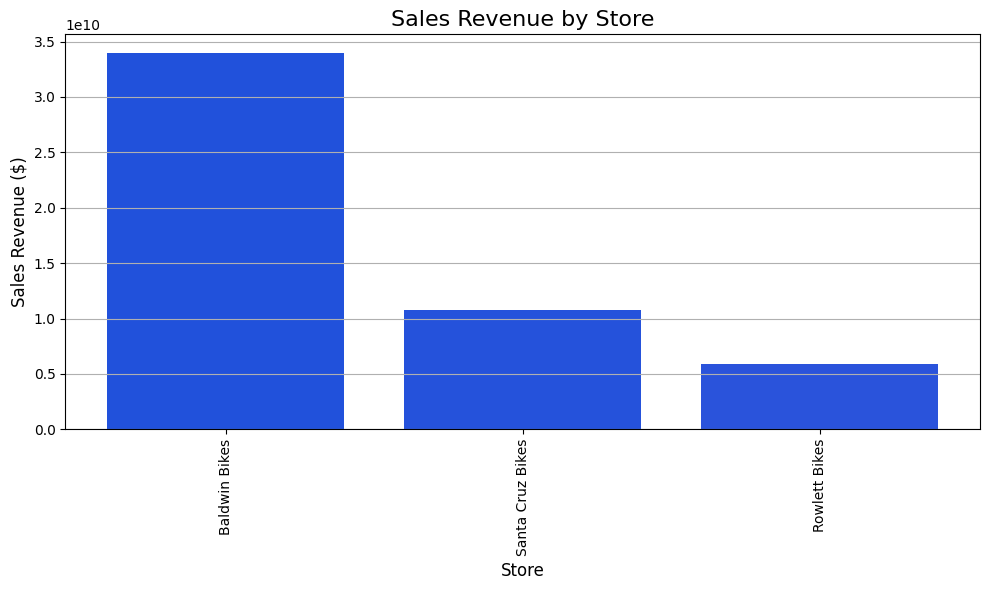

In [ ]:
# Query to find sales revenue for each store
cursor.execute("""
    SELECT st.store_id, st.store_name, SUM(stk.quantity * p.list_price) AS sales_revenue
    FROM sales.orders o
    JOIN sales.stores st ON o.store_id = st.store_id  
    JOIN sales.order_items oi ON o.order_id = oi.order_id  
    JOIN production.stocks stk ON st.store_id = stk.store_id  
    JOIN production.products p ON oi.product_id = p.product_id 
    GROUP BY st.store_id, st.store_name
    ORDER BY sales_revenue DESC;
""")

# Fetch all results
results = cursor.fetchall()

# Prepare data for plotting and printing
store_names = [row[1] for row in results]
sales_revenue = [row[2] for row in results]

# Print the headers
print(f"{'store_id':<10} {'store_name':<30} {'sales_revenue':<15}")
print("="*55)

# Print the results and format the sales revenue
for row in results:
    store_id = row[0]
    store_name = row[1]
    sales_revenue_value = row[2]

    # Format the sales_revenue to display as dollar accounting format
    formatted_sales_revenue = "${:,.2f}".format(sales_revenue_value)

    # Print formatted output
    print(f"{store_id:<10} {store_name:<30} {formatted_sales_revenue:<15}")

# Plotting
plt.figure(figsize=(10, 6))

# Use a colormap from colorcet
plt.bar(store_names, sales_revenue, color=cc.cm.coolwarm(range(len(sales_revenue))))

# Title and labels
plt.title('Sales Revenue by Store', fontsize=16)
plt.xlabel('Store', fontsize=12)
plt.ylabel('Sales Revenue ($)', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add a grid for better visualization
plt.grid(True, axis='y')

# Show the plot
plt.tight_layout()
plt.show()

In [76]:
# Query to find the number of customers for each store
cursor.execute("""
    SELECT st.store_name, COUNT(o.customer_id) AS total_customers
    FROM sales.orders o
    JOIN sales.stores st ON o.store_id = st.store_id
    GROUP BY st.store_name
    ORDER BY total_customers DESC;
""")

# Fetch all results
results = cursor.fetchall()

# Print the headers
print(f"{'store_name':<30} {'total_customers':<15}")
print("="*45)

# Print the results
for row in results:
    store_name = row[0].strip()  # Remove any leading/trailing spaces for each store
    total_customers = row[1]
    
    # Print formatted output
    print(f"{store_name:<30} {total_customers:<15}")


store_name                     total_customers
Baldwin Bikes                  1093           
Santa Cruz Bikes               348            
Rowlett Bikes                  174            


#### A1. The results indicate that having more staff in a store does not necessarily lead to higher revenue. However, management should consider increasing the number of staff at the Baldwin Bikes store, as it attracts more customers and generates higher revenue.

#### Q2: Which product sold the most?

category_name                  total_units_sold
Cruisers Bicycles              2063           
Mountain Bikes                 1755           
Children Bicycles              1179           
Comfort Bicycles               813            
Road Bikes                     559            
Cyclocross Bicycles            394            
Electric Bikes                 315            


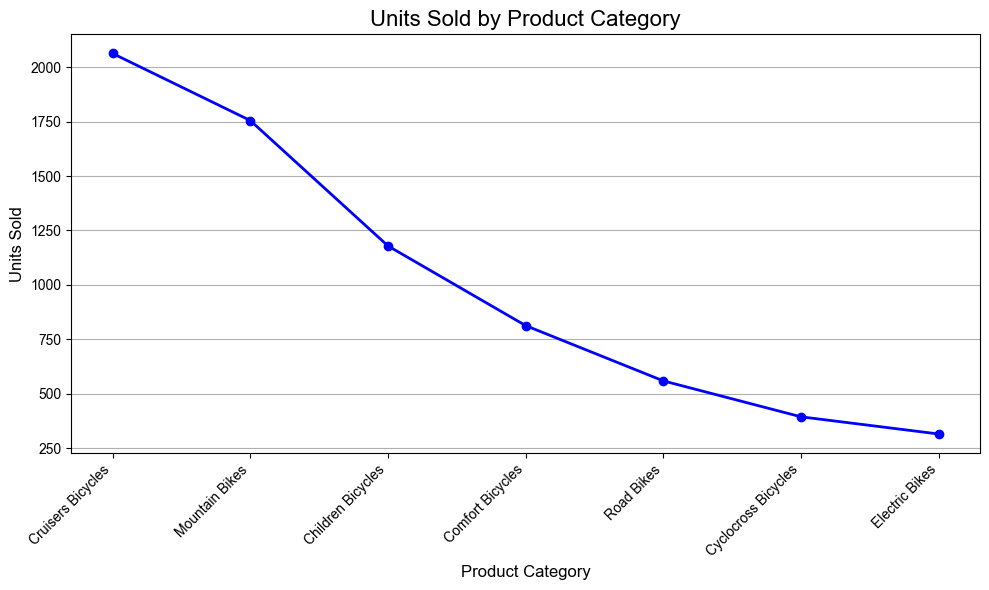

In [ ]:
# Query to find the products that have the most unit sold
cursor.execute("""
    SELECT c.category_name, SUM(oi.quantity) AS total_units_sold
    FROM sales.order_items oi
    JOIN production.products p ON oi.product_id = p.product_id
    JOIN production.categories c ON p.category_id = c.category_id
    GROUP BY c.category_name
    ORDER BY total_units_sold DESC;
""")

# Fetch all results
results = cursor.fetchall()

# Prepare data for plotting
category_names = [row[0].strip() for row in results]  # Strip spaces from category names
units_sold = [row[1] for row in results]

# Print the headers
print(f"{'category_name':<30} {'total_units_sold':<15}")
print("="*45)

# Print the results
for row in results:
    category_name = row[0].strip()  # Remove any leading/trailing spaces for each category
    total_units_sold = row[1]
    
    # Print formatted output
    print(f"{category_name:<30} {total_units_sold:<15}")

# Plotting
plt.figure(figsize=(10, 6))

# Plot line chart
plt.plot(category_names, units_sold, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)

# Title and labels
plt.title('Units Sold by Product Category', fontsize=16)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a grid for better visualization
plt.grid(True, axis='y')

# Show the plot
plt.tight_layout()
plt.show()


In [74]:
# Query to find the number of products in each category
cursor.execute("""
    SELECT c.category_name, COUNT(p.product_id) AS total_products
    FROM production.products p
    JOIN production.categories c ON p.category_id = c.category_id
    GROUP BY c.category_name
    ORDER BY total_products DESC;
""")

# Fetch all results
results = cursor.fetchall()

# Print the headers
print(f"{'category_name':<30} {'total_products':<15}")
print("="*45)

# Print the results
for row in results:
    category_name = row[0].strip()
    total_products = row[1]
    
    # Print formatted output
    print(f"{category_name:<30} {total_products:<15}")


category_name                  total_products 
Cruisers Bicycles              78             
Mountain Bikes                 60             
Road Bikes                     60             
Children Bicycles              59             
Comfort Bicycles               30             
Electric Bikes                 24             
Cyclocross Bicycles            10             


#### A2: Cruisers Bicycles are the leading product category in terms of sales and have the highest number of products available within that category.

#### Q3: Does the store have enough products stocked?

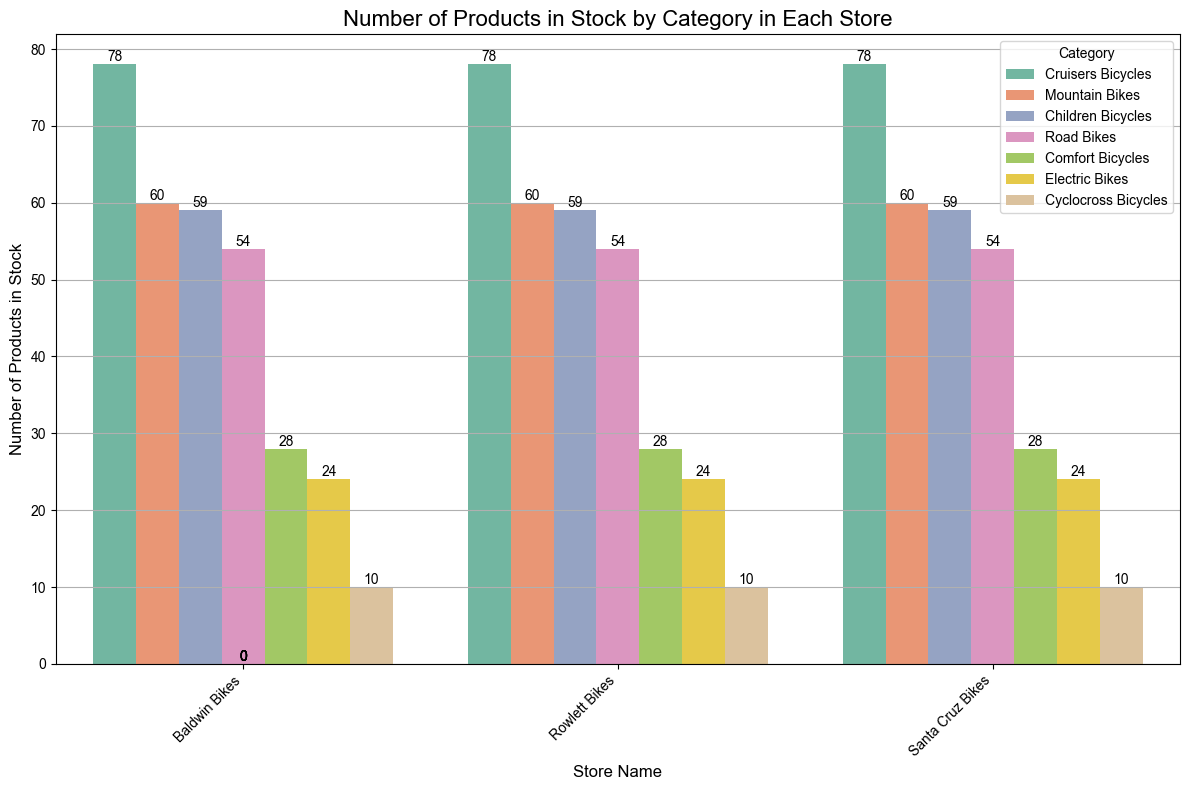

In [79]:
# Query to find how many products of each category are in stock at each store
cursor.execute("""
    SELECT st.store_name, c.category_name, COUNT(DISTINCT stk.product_id) AS products_in_stock
    FROM production.stocks stk
    JOIN production.products p ON stk.product_id = p.product_id
    JOIN production.categories c ON p.category_id = c.category_id
    JOIN sales.stores st ON stk.store_id = st.store_id
    GROUP BY st.store_name, c.category_name
    ORDER BY st.store_name, products_in_stock DESC;
""")

# Fetch all results
results = cursor.fetchall()

# Prepare data for plotting
store_names = [row[0].strip() for row in results]
category_names = [row[1].strip() for row in results]
products_in_stock = [row[2] for row in results]

# Create a dataframe for better handling
df = pd.DataFrame({
    'Store Name': store_names,
    'Category': category_names,
    'Products in Stock': products_in_stock
})

# Plotting
plt.figure(figsize=(12, 8))

# Create a bar plot with stores on the x-axis and products in stock on the y-axis
ax = sns.barplot(x='Store Name', y='Products in Stock', hue='Category', data=df, palette='Set2')

# Title and labels
plt.title('Number of Products in Stock by Category in Each Store', fontsize=16)
plt.xlabel('Store Name', fontsize=12)
plt.ylabel('Number of Products in Stock', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Add a grid for better visualization
plt.grid(True, axis='y')

# Show the plot
plt.tight_layout()
plt.show()

#### A3: Since all stores have the same quantity of products, management should consider redistributing some of the inventory to the stores with the highest customer traffic and revenue to maximize sales potential.

#### Q4: What is the most popular brand and no of unit sold?

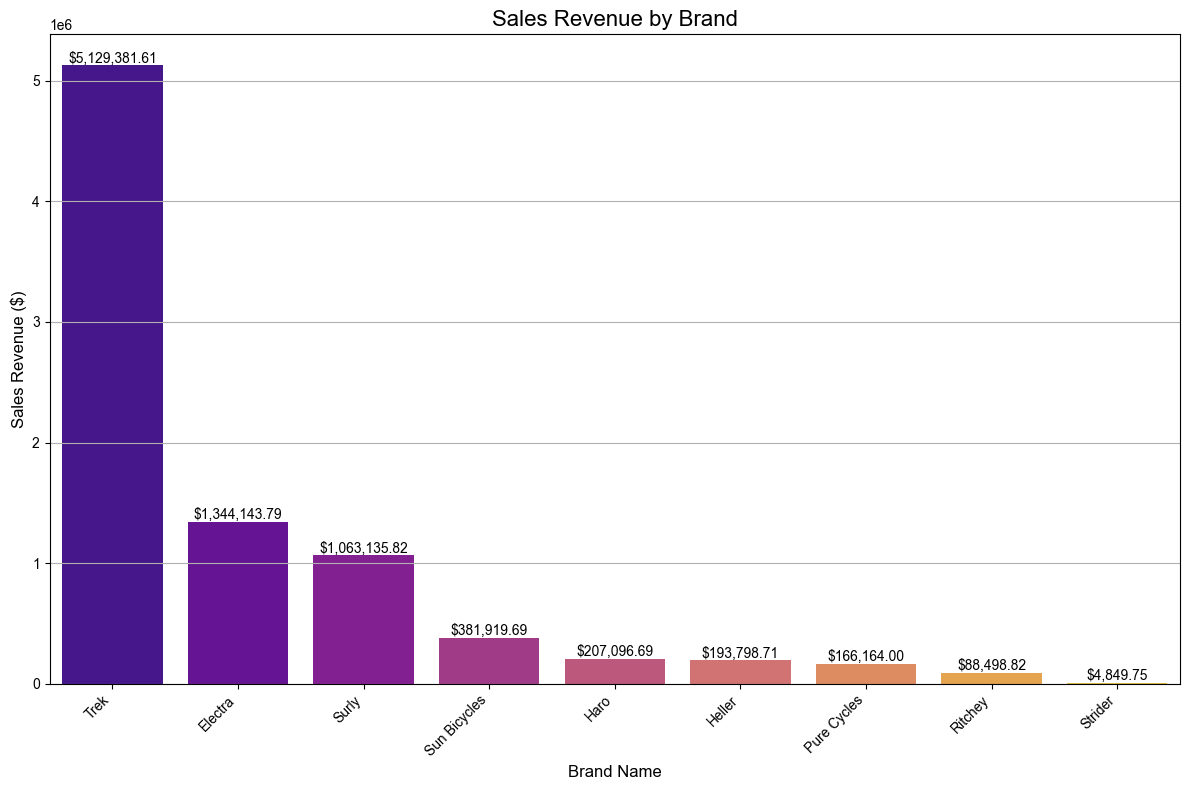

In [8]:
# Query to find the most popular brand based on total sales revenue
cursor.execute("""
    SELECT b.brand_name, SUM(oi.quantity * p.list_price) AS total_sales_revenue
    FROM sales.order_items oi
    JOIN production.products p ON oi.product_id = p.product_id
    JOIN production.brands b ON p.brand_id = b.brand_id
    GROUP BY b.brand_name
    ORDER BY total_sales_revenue DESC;
""")

# Fetch all results
results = cursor.fetchall()

# Prepare data for plotting
brand_names = [row[0].strip() for row in results]
sales_revenue = [row[1] for row in results]

# Create a dataframe for better handling
df = pd.DataFrame({
    'Brand Name': brand_names,
    'Sales Revenue ($)': sales_revenue
})

# Plotting the sales revenue of each brand
plt.figure(figsize=(12, 8))

# Create a bar plot with brand names on the x-axis and sales revenue on the y-axis
ax = sns.barplot(x='Brand Name', y='Sales Revenue ($)', data=df, hue='Brand Name', legend=False, palette='plasma')

# Title and labels
plt.title('Sales Revenue by Brand', fontsize=16)
plt.xlabel('Brand Name', fontsize=12)
plt.ylabel('Sales Revenue ($)', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels on top of the bars
for p in ax.patches:
    ax.annotate(f'${p.get_height():,.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Add a grid for better visualization
plt.grid(True, axis='y')

# Show the plot
plt.tight_layout()
plt.show()

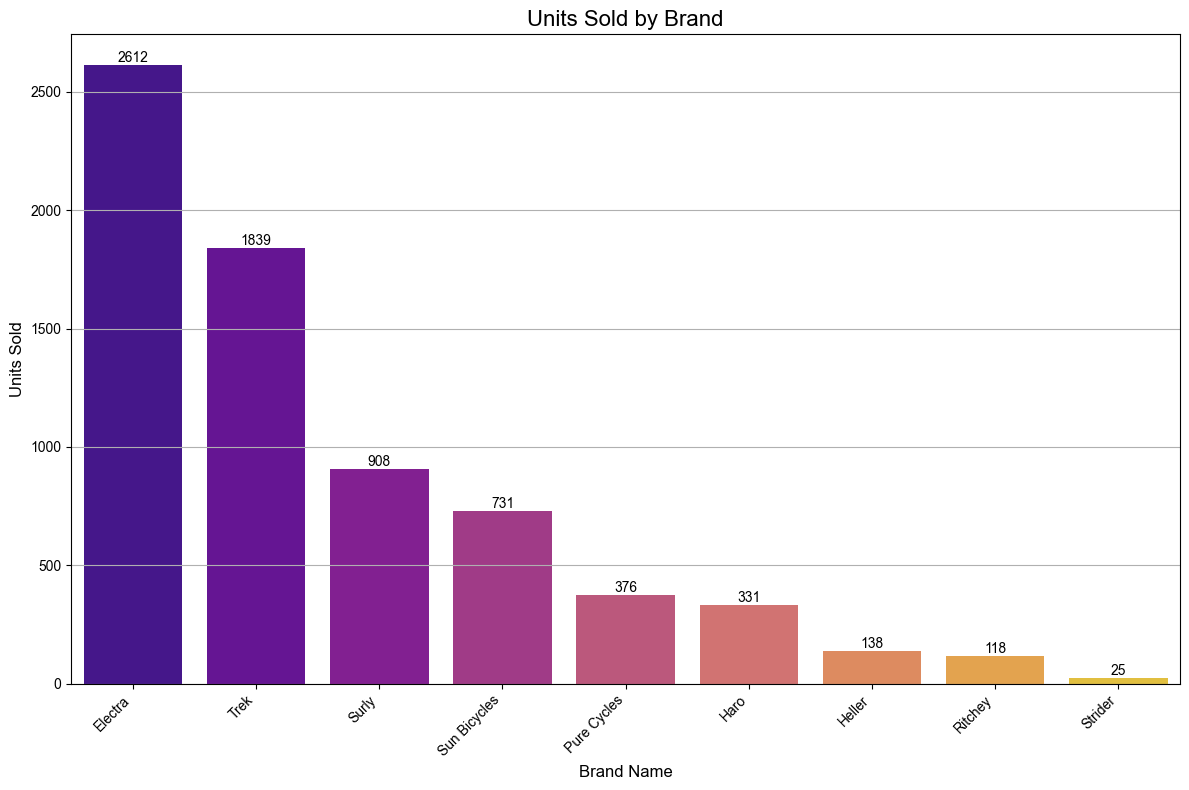

In [7]:
# Query to find the most popular brand based on total units sold
cursor.execute("""
    SELECT b.brand_name, SUM(oi.quantity) AS total_units_sold
    FROM sales.order_items oi
    JOIN production.products p ON oi.product_id = p.product_id
    JOIN production.brands b ON p.brand_id = b.brand_id
    GROUP BY b.brand_name
    ORDER BY total_units_sold DESC;
""")

# Fetch all results
results_units = cursor.fetchall()

# Prepare data for plotting units sold
brand_names_units = [row[0].strip() for row in results_units]
units_sold = [row[1] for row in results_units]

# Create a dataframe for better handling
df_units = pd.DataFrame({
    'Brand Name': brand_names_units,
    'Units Sold': units_sold
})

# Plotting the units sold for each brand
plt.figure(figsize=(12, 8))

# Create a bar plot with brand names on the x-axis and units sold on the y-axis
ax_units = sns.barplot(x='Brand Name', y='Units Sold', data=df_units, hue='Brand Name', legend=False, palette='plasma')

# Title and labels
plt.title('Units Sold by Brand', fontsize=16)
plt.xlabel('Brand Name', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels on top of the bars
for p in ax_units.patches:
    ax_units.annotate(f'{int(p.get_height())}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='center', 
                      fontsize=10, color='black', 
                      xytext=(0, 5), textcoords='offset points')

# Add a grid for better visualization
plt.grid(True, axis='y')

# Show the plot
plt.tight_layout()
plt.show()

#### A4: Trek generates higher revenue despite Electra selling more units, indicating that Trek's products are priced at a higher rate.

### Recommendation
**Membership**: Retaining customers is crucial for business success. By implementing a membership program, the company can analyze the age groups of its most frequent buyers as well as those who visit less often. This data allows the company to tailor its product offerings to better align with the preferences and needs of its key customer segments.  

**Marketing campaign**: Marketing efforts boost the shop's visibility and can drive revenue growth. It is advisable to begin with smaller-scale campaigns, carefully evaluating the costs against the revenue generated to ensure a positive return on investment.  

**Authorised brand seller**: The company should strive to become an authorized brand seller, as the market is flooded with counterfeit products that can often mimic high quality. Becoming an authorized seller ensures customer trust, provides authenticity, and prevents counterfeiters from profiting at the company's expense.